# BERT - Climate Sentiment Multiclass Classification
## CS522 Project

**Dataset:**  
https://www.kaggle.com/code/luiskalckstein/climate-sentiment-multiclass-classification

**Imports**

In [35]:
# ! pip install tensorflow-addons
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
from transformers import logging as hf_logging
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from Common.UtilFuncs import DataSize
from Common.DataCenter import data_center
from Common.UtilFuncs import print_evaluation, print_distribution

hf_logging.set_verbosity_error()
warnings.filterwarnings('ignore')
# ! pip install tensorflow-addons
TrainSizeBaseLine = DataSize.GetTrainSizeBaseline()
TrainSizeWithNoisyData = DataSize.GetTrainSizeWithNoisyData()
TestDataSize = DataSize.GetTestDataSize()
NoiseDataSize = DataSize.GetNoiseDataSize()
ValidationDataSize = DataSize.GetValidationDataSize()

%matplotlib inline

**Detect GPU**

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print('Set memory autoincrement')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print('Physical GPUs: %d, Logical GPUs: %d' % (len(gpus), len(logical_gpus)))
  except RuntimeError as e:
    print(e)
else:
    print('GPUs not detected')

Set memory autoincrement
Physical GPUs: 4, Logical GPUs: 4


2022-04-09 18:38:15.174566: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-09 18:38:31.595656: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21032 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:06:00.0, compute capability: 8.6
2022-04-09 18:38:31.598784: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21032 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:07:00.0, compute capability: 8.6
2022-04-09 18:38:31.600444: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/

## 1. Loading Dataset

In [3]:
def dc_format(D):
    data = {'message':D[0] , 'sentiment':D[1]}
    df = pd.DataFrame(data)
    return df

In [4]:
noisy_set_sizes = {
    'mislabeled' : 5000,   # max size: 15000
    'irrelevant' : 5000,   # max size: 34259
    'translated' : 5000,   # max size: 5000
}

# Load the database and split it into training set, test set, noisy set, validation set
dc = data_center('twitter_sentiment_data_clean.csv', test_size = 4000, validation_size = 1000,
                 noisy_size = noisy_set_sizes['mislabeled'])

test_df = dc_format(dc.get_test())
val_df = dc_format(dc.get_validation())

print(f"Test size: {test_df.shape[0]}")
print(f"Validation size: {val_df.shape[0]}")

Test size: 4000
Validation size: 1000


### Prepare the noisy set.

In [5]:
lstNoisyInfo = [("mislabeled",dc.get_noisy_len())]
print("Noisy set size is %d"                % dc.get_noisy_len())

# add the external noisy data (irrelevant texts)
# distribution of irrelevant noisy
irrelevant_noisy_distribution = [0.25, 0.25, 0.25, 0.25]    # None, if use the distribution of original set
added_size = dc.add_noisy(noisy_source="irrelevant", distribution = irrelevant_noisy_distribution,
                          size = noisy_set_sizes['irrelevant'])
print("%d noisy samples added" % added_size)
lstNoisyInfo.append(("irrelevant",added_size))

# add the external noisy data (translated texts). use the labels of each noisy data
added_size = dc.add_noisy(noisy_source="translated", distribution = "reserve_labels", 
                          size = noisy_set_sizes['translated'])
print("%d noisy samples added" % added_size)
lstNoisyInfo.append(("translated",added_size))

print("Noisy set new size is %d"                % dc.get_noisy_len())

Noisy set size is 5000
5000 noisy samples added
5000 noisy samples added
Noisy set new size is 15000


In [6]:
TrainSizeBaseLine

[2000, 4000, 5000, 8000, 10000, 15000, 20000]

In [7]:
TrainSizeWithNoisyData

[(4000, 1000), (8000, 2000), (15000, 5000)]

In [8]:
train_distribution = None

In [9]:
# 2000
train_df_2000 = dc_format(dc.get_train(TrainSizeBaseLine[0], train_distribution))
# 4000
train_df_4000 = dc_format(dc.get_train(TrainSizeBaseLine[1], train_distribution))
# 5000
train_df_5000 = dc_format(dc.get_train(TrainSizeBaseLine[2], train_distribution))
# 8000
train_df_8000 = dc_format(dc.get_train(TrainSizeBaseLine[3], train_distribution))
# 10000
train_df_10000 = dc_format(dc.get_train(TrainSizeBaseLine[4], train_distribution))
# 15000
train_df_15000 = dc_format(dc.get_train(TrainSizeBaseLine[5], train_distribution))
# 20000
train_df_20000 = dc_format(dc.get_train(TrainSizeBaseLine[6], train_distribution))

In [10]:
# (4000, 1000)
train_df_4000_1000 = dc_format(dc.get_train_with_noisy(TrainSizeWithNoisyData[0][0], TrainSizeWithNoisyData[0][1], train_distribution))
# (8000, 2000)
train_df_8000_2000 = dc_format(dc.get_train_with_noisy(TrainSizeWithNoisyData[1][0], TrainSizeWithNoisyData[1][1], train_distribution))
# (15000, 5000)
train_df_15000_5000 = dc_format(dc.get_train_with_noisy(TrainSizeWithNoisyData[2][0], TrainSizeWithNoisyData[2][1], train_distribution))

### <font color='red'> Specified training set </font>

In [11]:
train_df = train_df_2000

In [12]:
train_df.head()

,message,sentiment
0,RT @NYTScience: Americans overwhelmingly belie...,3
1,RT @nature_org: #DYK: Forests could contribute...,2
2,RT @mmfa: Five crucial climate change takeaway...,3
3,@YogiBabaPrem @FOTCangela @CNN @DrJillStein We...,2
4,RT @washingtonpost: Scientists just measured a...,3


#### Label Encoding

In [13]:
le = LabelEncoder()
train_df['sparse_label'] = le.fit_transform(train_df['sentiment'])
val_df['sparse_label'] = le.transform(val_df['sentiment'])
test_df['sparse_label'] = le.transform(test_df['sentiment'])

In [14]:
label_dict = (train_df[['sentiment','sparse_label']].drop_duplicates()
              .sort_values(by='sparse_label')
              .reset_index(drop=True)['sentiment']
              .to_dict())

for index, key in label_dict.items():
    print(index, key)

0 0
1 1
2 2
3 3


#### Splitting dataset

In [15]:
x_train = train_df['message']
y_train = train_df['sparse_label']

x_val = val_df['message']
y_val = val_df['sparse_label']

print(f"{len(x_train)} training samples\n{len(x_val)} validation samples")

2000 training samples
1000 validation samples


In [16]:
x_test = test_df['message']
y_test = test_df['sparse_label']
print(f"{len(x_test)} testing samples")

4000 testing samples


## 2. Train BERT

In [17]:
MODEL_NAME = 'distilbert-base-uncased'

In [18]:
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

In [19]:
max_len = 0
for sentence in (x_train.tolist() + x_val.tolist()):
    try:
        sentence_token_len = len(tokenizer.tokenize(sentence))
        max_len = sentence_token_len if (sentence_token_len > max_len) else max_len
    except:
        pass
    
print(f"The maximum amount of tokens in the dataset is {max_len}")

The maximum amount of tokens in the dataset is 100


In [22]:
MAX_LEN = 360

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME,  
                                                add_special_tokens=True,
                                                max_length=MAX_LEN, 
                                                pad_to_max_length=True)

def tokenize(sentences):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence, 
                                       add_special_tokens=True, 
                                       max_length=MAX_LEN, 
                                       pad_to_max_length=True, 
                                       return_attention_mask=True, 
                                       return_token_type_ids=True, 
                                       truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])       
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')

In [23]:
X_train = tokenize(x_train)
X_val = tokenize(x_val)
X_test = tokenize(x_test)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:02<00:00, 1716.97it/s]


#### Add custom layers after embedding model for classification

In [95]:
bert_config = DistilBertConfig.from_pretrained(MODEL_NAME, output_hidden_states=True, output_attentions=True)
TFBert = TFDistilBertModel.from_pretrained(MODEL_NAME, config=bert_config)

input_ids_layer = tf.keras.layers.Input(shape=(MAX_LEN,), name='input_token', dtype='int32')
input_masks_layer = tf.keras.layers.Input(shape=(MAX_LEN,), name='masked_token', dtype='int32') 

X = TFBert(input_ids = input_ids_layer, attention_mask = input_masks_layer)[0]
# X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(X)
# X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(1024, activation=tfa.activations.mish)(X)
X = tf.keras.layers.Flatten()(X)
X = tf.keras.layers.Dense(4, activation=tf.nn.softmax)(X)

model = tf.keras.Model(inputs=[input_ids_layer, input_masks_layer], outputs = X)

for layer in model.layers[:3]:
    layer.trainable = True

In [96]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 360)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 360)]        0           []                               
                                                                                                  
 tf_distil_bert_model_5 (TFDist  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 ilBertModel)                   ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 360, 768),                                                   
                                 hidden_states=((No                                         

#### Model callbacks

In [97]:
ckpt_dir = './ckpt'
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

In [111]:
model_checkpoint = ModelCheckpoint(filepath=ckpt_dir + '/weights_val_best.hdf5',
                                   monitor='val_accuracy',
                                   save_weights_only=True,
                                   save_best_only=True,
                                   verbose=0)

early_stopping = EarlyStopping(patience=3,
                               monitor='val_accuracy',
                               min_delta=0,
                               mode='max',
                               restore_best_weights=False,
                               verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              min_lr=0.000001,
                              patience=1,
                              mode='min',
                              factor=0.1,
                              min_delta=0.0001,
                              verbose=1)

In [112]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tfa.optimizers.RectifiedAdam(0.0001),
              metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[model_checkpoint, early_stopping, reduce_lr])

Epoch 1/50
125/125 [==============================] - 33s 192ms/step - loss: 0.0847 - accuracy: 0.9740 - val_loss: 1.1054 - val_accuracy: 0.6620 - lr: 1.0000e-04
Epoch 2/50
125/125 [==============================] - ETA: 0s - loss: 0.0423 - accuracy: 0.9900
Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
125/125 [==============================] - 22s 173ms/step - loss: 0.0423 - accuracy: 0.9900 - val_loss: 1.6000 - val_accuracy: 0.6510 - lr: 1.0000e-04
Epoch 3/50
125/125 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.9970
Epoch 3: ReduceLROnPlateau reducing learning rate to 1e-06.
125/125 [==============================] - 23s 181ms/step - loss: 0.0166 - accuracy: 0.9970 - val_loss: 1.5849 - val_accuracy: 0.6780 - lr: 1.0000e-05
Epoch 4/50
125/125 [==============================] - 23s 181ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 1.5883 - val_accuracy: 0.6800 - lr: 1.0000e-06
Epoch 5/50
125/125 [==========================

In [113]:
def plot_graphs(history, metric, title=''):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history[metric],  label='Training')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.title(title)
    plt.legend()
    plt.show()

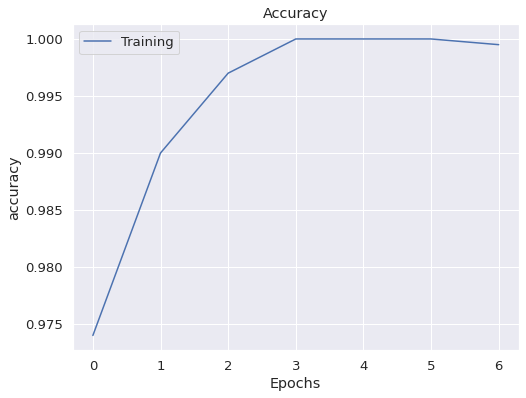

In [114]:
plot_graphs(history, 'accuracy', 'Accuracy')

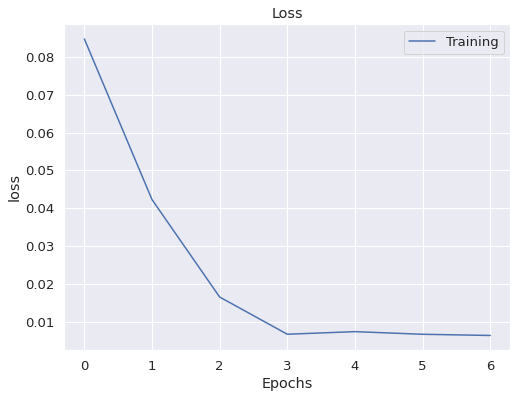

In [115]:
plot_graphs(history, 'loss', 'Loss')

#### Loading the best model and test on a test set

In [116]:
model.load_weights(ckpt_dir + '/weights_val_best.hdf5')

In [117]:
pred_probs = model.predict(X_test)
y_pred = np.argmax(pred_probs, axis=1)

#### Visualizing Confusion Matrix using Heatmap

In [118]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 111,   56,  187,   22],
       [  49,  284,  334,   65],
       [  62,  147, 1593,  207],
       [   7,   13,  153,  710]])

Test Accuracy: 0.6745


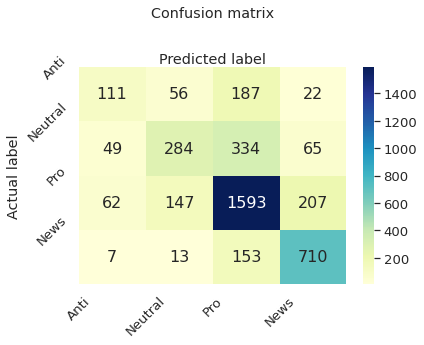

In [119]:
labels_names = ['Anti','Neutral','Pro','News'] 
class_names=[0, 1, 2, 3]

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

sns.set(font_scale = 1.2, color_codes=True, palette='deep')
sns.heatmap(pd.DataFrame(cm, index=labels_names ,columns=class_names), annot=True, annot_kws = {'size':16}, cmap='YlGnBu' ,fmt='g')
ax.xaxis.set_label_position('top')
plt.xticks(class_names, labels_names, rotation=45)
plt.yticks(class_names, labels_names, rotation=45)
plt.title('Confusion matrix', y=1.2)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('Test Accuracy:', accuracy_score(y_test, y_pred))

In [120]:
print(classification_report(y_test, y_pred, target_names=labels_names))

              precision    recall  f1-score   support

        Anti       0.48      0.30      0.37       376
     Neutral       0.57      0.39      0.46       732
         Pro       0.70      0.79      0.75      2009
        News       0.71      0.80      0.75       883

    accuracy                           0.67      4000
   macro avg       0.62      0.57      0.58      4000
weighted avg       0.66      0.67      0.66      4000



In [121]:
# mf = f1_score(y_test, y_pred, average='macro')
# wf = f1_score(y_test, y_pred, average='weighted')
# mp = precision_score(y_test, y_pred, average='macro')
# mr = recall_score(y_test, y_pred, average='macro')

In [122]:
# print(
#     f'Macro F1: {mf: .3f} \
#     | Weighted F1: {wf: .3f} \
#     | Macro Precision: {mp: .3f} \
#     | Macro recall: {mr: .3f}'
# )

In [123]:
print_evaluation(y_test,y_pred)

  f1 of classes: [0.367, 0.461, 0.745, 0.753]
  micro_f1: 0.674 , macro_f1: 0.581 , weighted_f1: 0.659, macro_precision: 0.616, macro_recall: 0.570
